# Notebook #5: Series temporales: a futuro del parque vehicular; Parámetros: p=3, d=1, q=2

In [97]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
from prophet import Prophet

# Importar las clases
# -----------------------------------------------------------------------
import sys
sys.path.append('../..')
from src import soporte_temporales as st
from src import soporte_sarima as ss
from src import soporte_funciones_BBDD as sfbd
from src import soporte_variables_vehiculos as svv

# Modelo Series Temporales
# -----------------------------------------------------------------------
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA



# Visualizar las métricas de error en y_test
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuraciones
# -----------------------------------------------------------------------
pd.options.display.float_format = '{:.0f}'.format
from itertools import product

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Modelo ARIMA

In [98]:
df_autos_historicos = sfbd.dbeaver_fetch(sfbd.dbeaver_conexion("proyecto_final"),svv.query_autos_historico)

In [99]:
df_autos_historicos.head()

,anio,total
0,1998,936083
1,1999,1090833
2,2000,1294998
3,2001,1436165
4,2002,1611023


In [100]:
df_autos_historicos.columns = ['FECHA', 'Vehículos']
df_autos_historicos['FECHA'] = pd.to_datetime(df_autos_historicos['FECHA'].astype(str) + '-12-31')

In [101]:
df_autos_historicos.head()

,FECHA,Vehículos
0,1998-12-31,936083
1,1999-12-31,1090833
2,2000-12-31,1294998
3,2001-12-31,1436165
4,2002-12-31,1611023


In [102]:
# instanciamos la clase
analisis_st = st.TimeSeriesAnalysis(df_autos_historicos, temporal_column="FECHA", value_column="Vehículos")

analisis_st.exploracion_datos()

El número de filas es 27 y el número de columnas es 1

----------

No hay duplicados

----------

No hay valores nulos

----------

Estadísticas de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Vehículos,27,3118597,1526266,936083,1823660,2917573,4224111,6160988


In [103]:
analisis_st.comprobar_serie_continua(freq='A')

La serie temporal es continua para la frecuencia 'A', no faltan periodos.


In [104]:
analisis_st.graficar_serie()

## Análisis de la serie temporal del parque vehicular

- Se puede observar una tendencia en ascenso, lo que indica que ha tenido un crecimiento uniforme en el transcurso del tiempo. A la vez, lo lógico nos dice que en un futuro esto serguirá en ascenso.

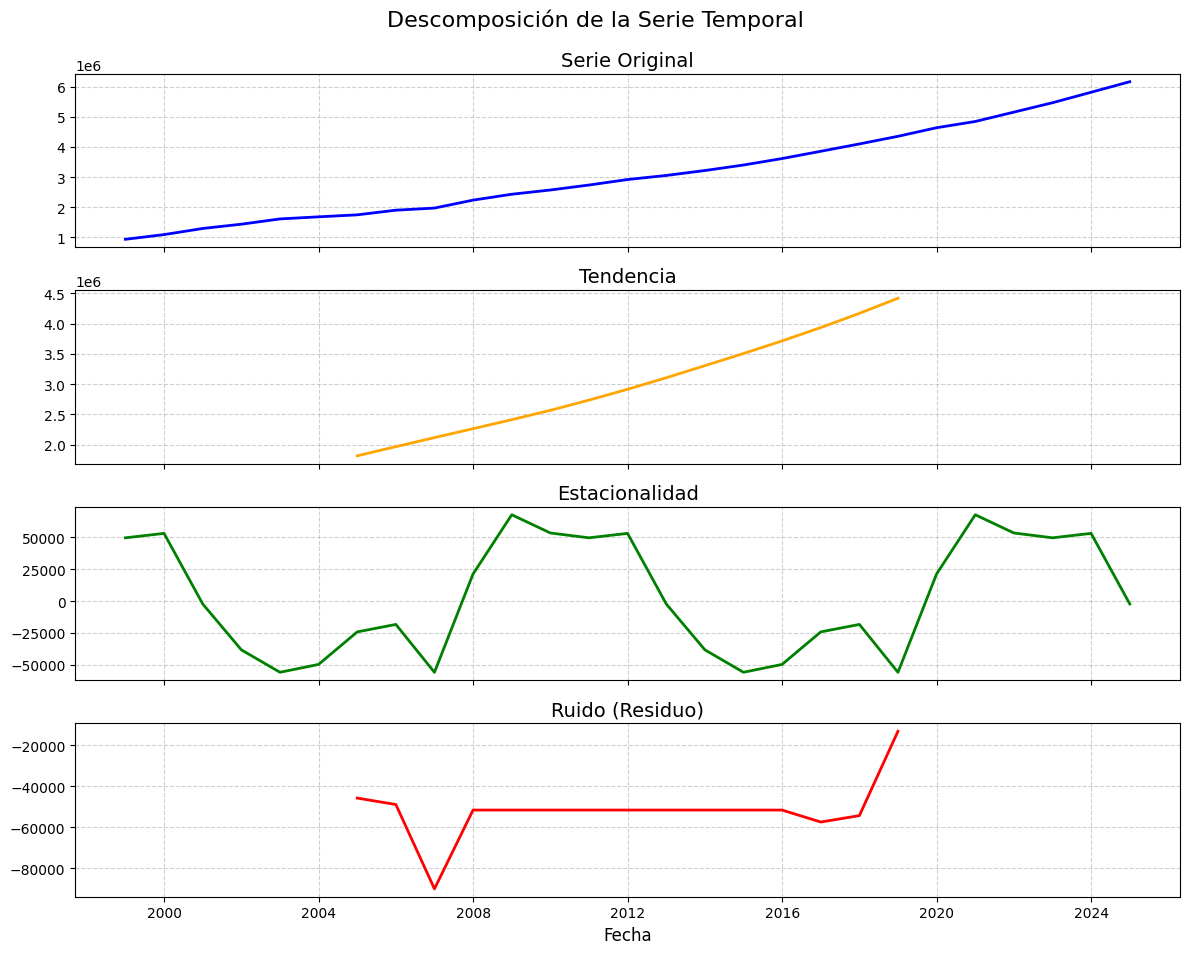

In [105]:
analisis_st.detectar_estacionalidad()

<Figure size 1200x1000 with 0 Axes>

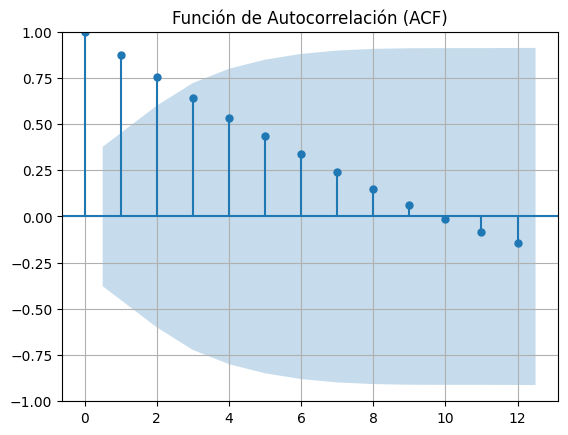

<Figure size 1200x1000 with 0 Axes>

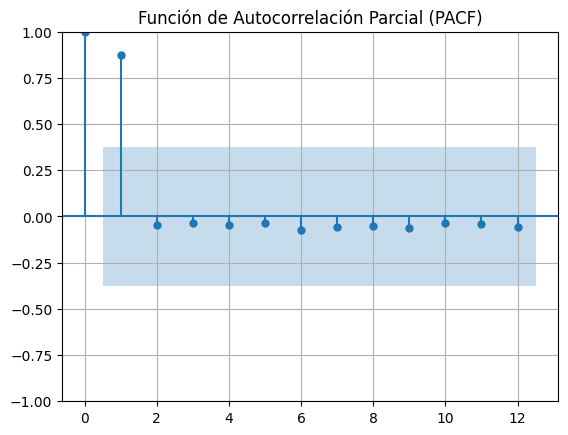

In [106]:
analisis_st.graficar_acf_pacf(lags=12)

## Análisis de las Gráficas ACF y PACF

### **Gráfica ACF (Función de Autocorrelación)**
1. **Lag 1**:
   - La correlación en el primer lag es muy alta, lo que indica que la variable tiene una fuerte relación con su valor del periodo inmediatamente anterior.
   
2. **Lags significativos**:
   - Los lags 2 y 3 tienen correlaciones significativas que sobresalen del intervalo de confianza, lo que sugiere que también tienen impacto en la serie.
   - Después del tercer lag, las correlaciones disminuyen gradualmente y se adentran al intervalo de confianza.

3. **Tendencia a cero**:
   - La autocorrelación disminuye de manera lenta y persistente, lo que podría ser indicativo de no estacionaridad o una estructura autorregresiva en la serie.

4. **Estacionalidad**:
   - No tiene estacionalidad ya que son datos anuales   
---

### **Gráfica PACF (Función de Autocorrelación Parcial)**
1. **Lag 1**:
   - El primer lag muestra una correlación significativa (cercana a 0.75), indicando que el valor actual está altamente influenciado por el valor del periodo inmediatamente anterior.

2. **Lags significativos**:
   - El segundo lag también tiene una fuerte conexión, sin embargo pasado este todos caen dentro del intervalo de confianza. De manera que los lags más lejanos no tienen influencia directa significativa.
---

In [107]:
analisis_st.prueba_estacionariedad()

ADF Statistic: 6.443519495590372
p-value: 1.0
Valores Críticos:
1%: -3.7112123008648155
5%: -2.981246804733728
10%: -2.6300945562130176
No podemos rechazar la hipótesis nula. La serie NO es estacionaria.


In [108]:
modelo_arima = st.ARIMAModel()

parametros_arima = modelo_arima.generar_parametros(p_range=range(1,6), q_range=range(1,6))
parametros_arima[:5]

[(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

## Dividir la serie en train-test

In [109]:
train_size= int(0.7 * len(df_autos_historicos))
df_autos_historicos.set_index('FECHA', inplace=True)
df_autos_historicos.index = pd.to_datetime(df_autos_historicos.index)

y_train, y_test = df_autos_historicos[:train_size], df_autos_historicos[train_size:]

In [110]:
resultados_arima = modelo_arima.evaluar_modelos(y_train, y_test, parametros_arima, diferenciacion=1)

100%|██████████| 25/25 [00:06<00:00,  3.79it/s]


In [111]:
resultados_arima.sort_values(by='RMSE', ascending=True).head()

,p,q,RMSE
22,5,3,286864
8,2,4,441328
13,3,4,473243
18,4,4,496192
3,1,4,552963


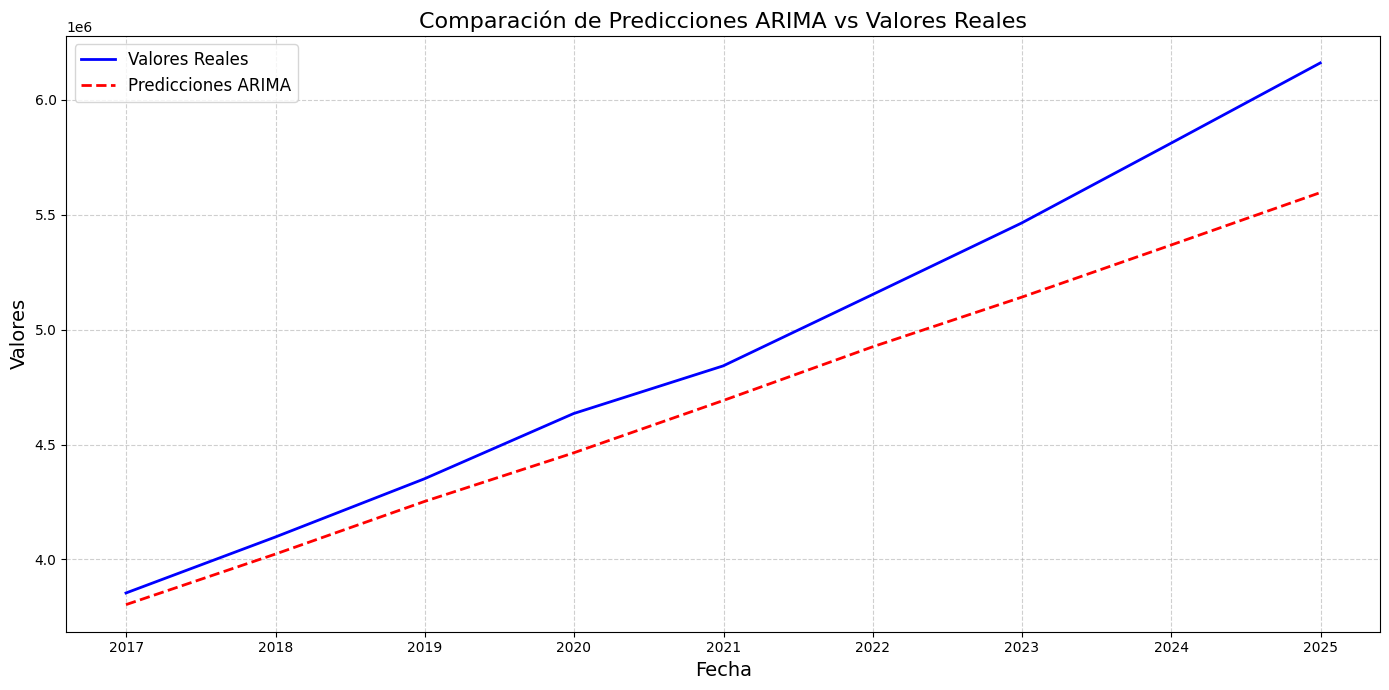

In [112]:
modelo_arima.visualizar_predicciones(y_test)

    - Evidentemente el modelo está subestimando para los últimos años. Vemoa su comportamiento para el conjunto completo.

In [113]:
modelo_arima.best_model['pred_test']

FECHA
2016-12-31   3803332
2017-12-31   4023024
2018-12-31   4252227
2019-12-31   4463717
2020-12-31   4691528
2021-12-31   4925008
2022-12-31   5141194
2023-12-31   5367834
2024-12-31   5596613
Name: predicted_mean, dtype: float64

In [114]:
modelo_arima.best_params # mejores parámetros para predecir

{'p': 5, 'q': 3}

## Cálculo de métricas para el y_test

In [115]:
mae = mean_absolute_error(y_test, modelo_arima.best_model["pred_test"])
mape = mean_absolute_percentage_error(y_test, modelo_arima.best_model["pred_test"])
rmse = np.sqrt(mean_squared_error(y_test, modelo_arima.best_model["pred_test"]))

print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

MAE: 233705.1634665636
MAPE: 4.37%
RMSE: 286864.49275469413


A pesar de que el valor de MAPE es bastante bueno, los valores del MAE y RMSE permanecen altos.

## Conjunto completo

## Aplicar parámetros según resultados

In [116]:
# Entrenar el modelo ARIMA con los mejores parámetros en toda la serie histórica
mejor_modelo_arima = ARIMA(
    pd.concat([y_train, y_test]),  # Usar toda la serie
    order=(3, 1, 2)  # Incluir el parámetro `d=1` o el que hayas usado
).fit()

mejor_modelo_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Vehículos   No. Observations:                   27
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -337.434
Date:                Wed, 22 Jan 2025   AIC                            686.869
Time:                        13:04:04   BIC                            694.417
Sample:                    12-31-1998   HQIC                           689.042
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0943      0.040      2.386      0.017       0.017       0.172
ar.L2          0.9987      0.053     18.748      0.000       0.894       1.103
ar.L3         -0.0929      0.054     -1.727      0.084      -0.198       0.013
ma.L1       4.344e-05      0.199      0.000      1.000      -0.390       0.390
ma.L2         -0.9982      0.132     -7.572      0.000      -1.257      -0.740
sigma2       2.37e+09   1.32e-10    1.8e+19      0.000    2.37e+09    2.37e+09
===================================================================================
Ljung-Box (L1) (Q):                   5.24   Jarque-Bera (JB):                 0.79
Prob(Q):                              0.02   Prob(JB):                         0.67
Heteroskedasticity (H):               1.85   Skew:                            -0.12
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.87e+34. Standard errors may be unstable.
"""

In [117]:
pred_todo = mejor_modelo_arima.predict(start=0, end=len(y_test) + len(y_train) - 1)
pred_df = pd.DataFrame({
    "Fecha": pd.concat([y_train, y_test]).index,
    "Valor Real": pd.concat([y_train, y_test])["Vehículos"],
    "Predicción": pred_todo
})
pred_df

,Fecha,Valor Real,Predicción
1998-12-31,1998-12-31,936083,0
1999-12-31,1999-12-31,1090833,1202540
2000-12-31,2000-12-31,1294998,1267552
2001-12-31,2001-12-31,1436165,1480329
2002-12-31,2002-12-31,1611023,1610091
2003-12-31,2003-12-31,1680382,1788663
2004-12-31,2004-12-31,1746756,1837580
2005-12-31,2005-12-31,1900564,1896437
2006-12-31,2006-12-31,1971011,2058210
2007-12-31,2007-12-31,2234307,2115008


In [118]:
mae_todo = mean_absolute_error(pred_df["Valor Real"], pred_df["Predicción"])
mape_todo = mean_absolute_percentage_error(pred_df["Valor Real"], pred_df["Predicción"])
rmse_todo = np.sqrt(mean_squared_error(pred_df["Valor Real"], pred_df["Predicción"]))

print(f"MAE para toda la serie: {mae_todo}")
print(f"MAPE para toda la serie: {mape_todo * 100:.2f}%")
print(f"RMSE para toda la serie: {rmse_todo}")

MAE para toda la serie: 95813.58972611593
MAPE para toda la serie: 5.95%
RMSE para toda la serie: 196011.3507121809


In [119]:
mae = mean_absolute_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:])
mape = mean_absolute_percentage_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:])
rmse = np.sqrt(mean_squared_error(pred_df["Valor Real"][1:], pred_df["Predicción"][1:]))

print(f"MAE: {mae}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"RMSE: {rmse}")

MAE: 63495.53548481269
MAPE: 2.33%
RMSE: 78715.83667445996


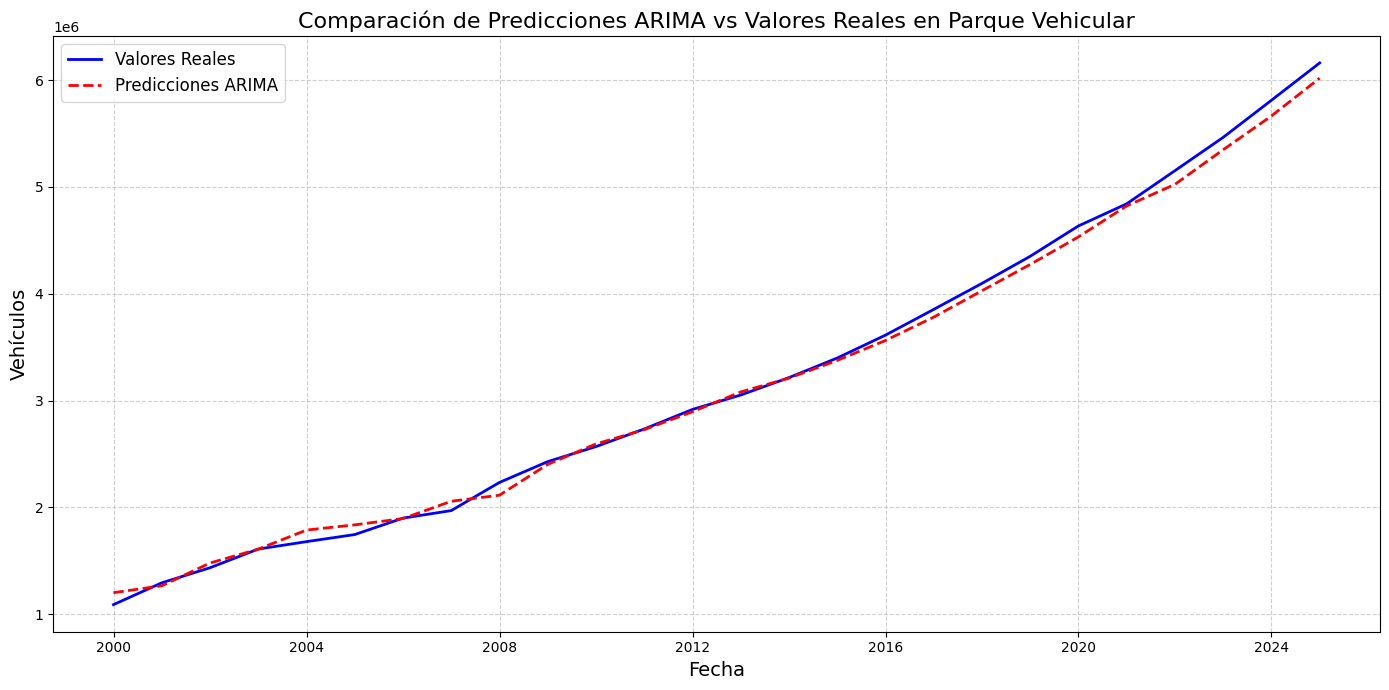

In [121]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=pred_df[1:], x="Fecha", y="Valor Real", label="Valores Reales", color="blue", linewidth=2) # valores reales
sns.lineplot(data=pred_df[1:], x="Fecha", y="Predicción", label="Predicciones ARIMA", color="red", linestyle="--", linewidth=2) # predicciones
plt.title("Comparación de Predicciones ARIMA vs Valores Reales en Parque Vehicular", fontsize=16)
plt.xlabel("Fecha", fontsize=14)
plt.ylabel("Vehículos", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6) # formato cuadriculado
plt.tight_layout()
plt.show()

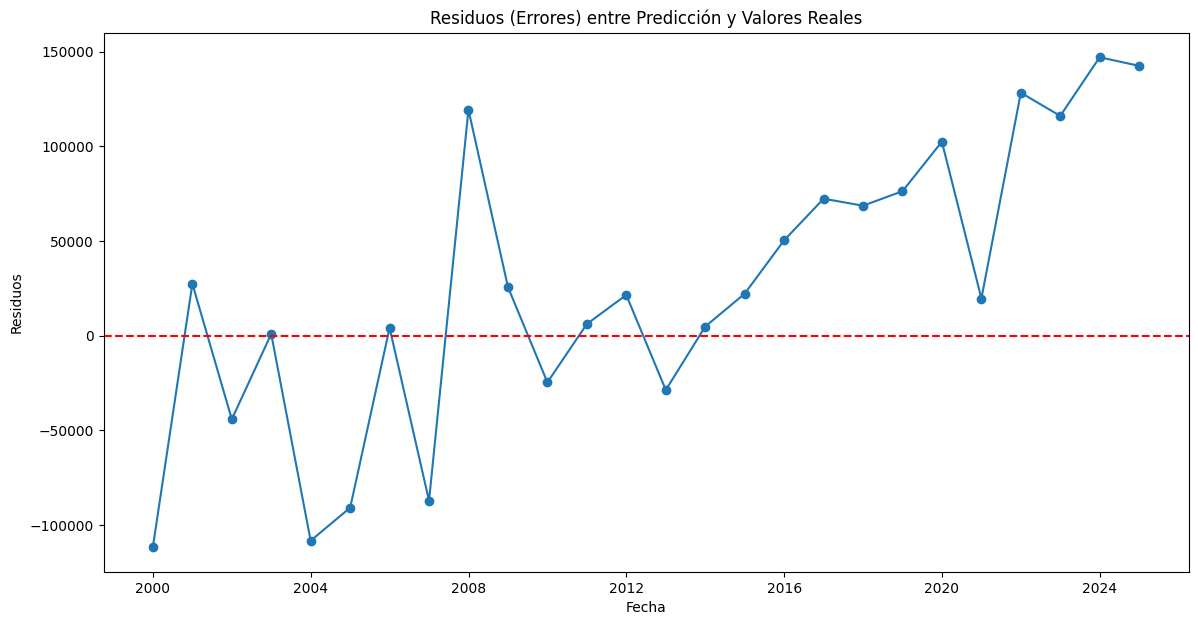

In [124]:
residuos = pred_df['Valor Real'] - pred_df['Predicción']
plt.figure(figsize=(14, 7))
plt.plot(pred_df["Fecha"][1:], residuos[1:], marker='o')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuos (Errores) entre Predicción y Valores Reales")
plt.xlabel("Fecha")
plt.ylabel("Residuos")
plt.show()

## Predicción a futuro (2 años)

In [122]:
# predicción de los próximos 2 años 
predicciones_futuras = mejor_modelo_arima.predict(start=len(y_train) + len(y_test), 
                                                  end=len(y_train) + len(y_test) + 2)
print(predicciones_futuras)

2025-12-31   6373719
2026-12-31   6573334
2027-12-31   6772062
Freq: A-DEC, Name: predicted_mean, dtype: float64


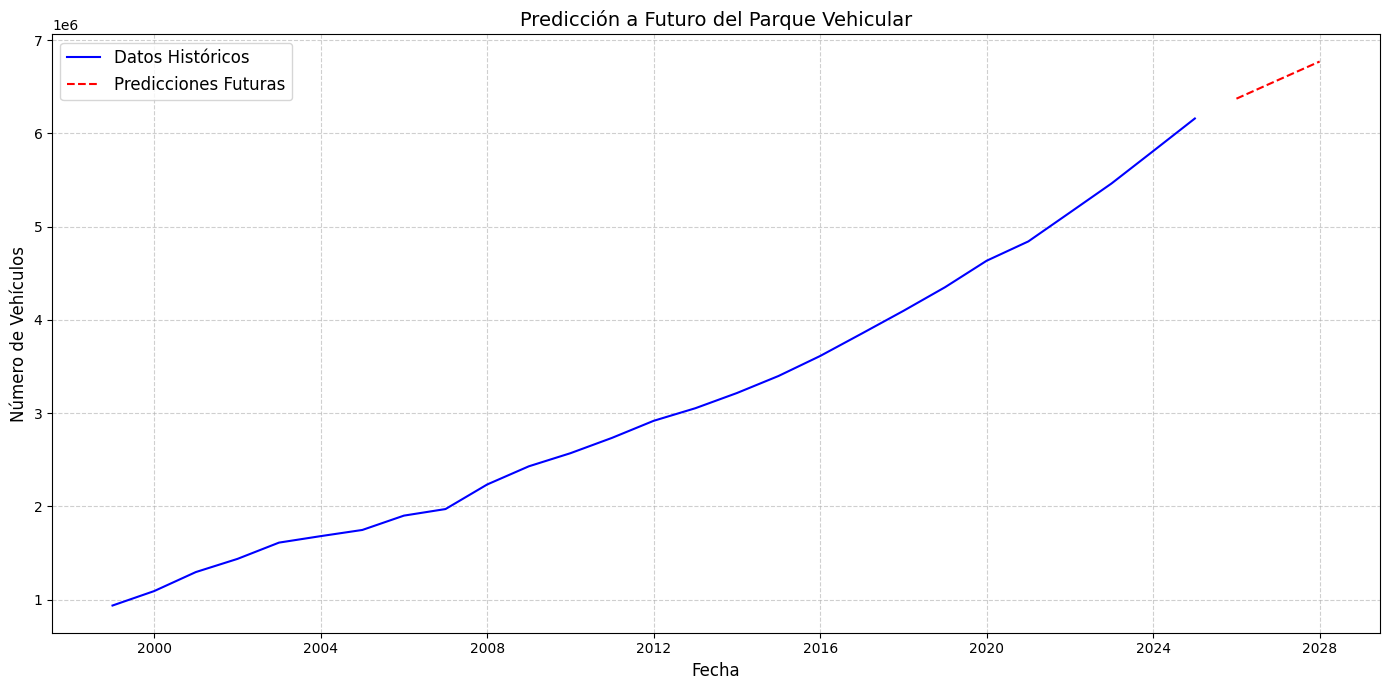

In [123]:
# rango de fechas para las predicciones futuras
fechas_futuras = pd.date_range(start=y_test.index[-1] + pd.DateOffset(1), periods=len(predicciones_futuras), freq='A')

# DataFrame para las predicciones futuras
predicciones_df = pd.DataFrame({
    'Fecha': fechas_futuras,
    'Predicción': predicciones_futuras
})

plt.figure(figsize=(14, 7))
plt.plot(pred_df['Fecha'], pred_df['Valor Real'], label='Datos Históricos', color='blue')
plt.plot(predicciones_df['Fecha'], predicciones_df['Predicción'], label='Predicciones Futuras', color='red', linestyle='--')

# Personalizar el gráfico
plt.title('Predicción a Futuro del Parque Vehicular', fontsize=14)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Vehículos', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
